# Classification of genre - logistic regression and hierarchical model

Importing required libraries:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import pystan
import pystan_utils
from sklearn.utils import shuffle

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

Loading data:

In [4]:
#### pop = 1 ####
pop1 = pd.read_csv("SpotifyAudioFeatures2017.csv")
pop2 = pd.read_csv("SpotifyAudioFeatures2018.csv")
pop3 = pd.read_csv("SpotifyAudioFeatures2019.csv")
df_pop = pd.concat([pop1, pop2,pop3])
df_pop["genre"] = [1]*len(df_pop)

#### metal = 2 ####
met1 = pd.read_csv("SpotifyAudioFeatures2017metal.csv")
met2 = pd.read_csv("SpotifyAudioFeatures2018metal.csv")
met3 = pd.read_csv("SpotifyAudioFeatures2019metal.csv")
df_met = pd.concat([met1, met2, met3])
#df_met = pd.read_csv("SpotifyAudioFeatures201720182019metal.csv")
df_met["genre"] = [2]*len(df_met)

#### classical = 3 ####
df_clas = pd.read_csv("SpotifyAudioFeaturesclassical.csv")
df_clas["genre"] = [3]*len(df_clas)

#### rap = 4 ####
rap1 = pd.read_csv("SpotifyAudioFeatures2017rap.csv")
rap2 = pd.read_csv("SpotifyAudioFeatures2018rap.csv")
rap3 = pd.read_csv("SpotifyAudioFeatures2019rap.csv")
df_rap = pd.concat([rap1, rap2, rap3])
#df_rap = pd.read_csv("SpotifyAudioFeatures201720182019rap.csv")
df_rap["genre"] = [4]*len(df_rap)

df = pd.concat([df_rap,df_met,df_clas,df_pop])
#df.to_csv("genredata.csv")

In [5]:
print("Shape of pop (1): ", df_pop.shape)
print("Shape of metal (2): ", df_met.shape)
print("Shape of classical (3): ", df_clas.shape) 
print("Shape of rap (4): ",df_rap.shape)

Shape of pop (1):  (6018, 19)
Shape of metal (2):  (6010, 19)
Shape of classical (3):  (5040, 19)
Shape of rap (4):  (5928, 19)


In [6]:
# load csv
df_tracks = pd.read_csv("genredata.csv")
df_tracks = df
#df_tracks = df_tracks.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1)
df_tracks = df_tracks.dropna(axis = 0)
df_tracks.head()

,Unnamed: 0,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genre
0,0,Metro Boomin,Up To Something (feat. Travis Scott & Young Thug),4RGacGFT2ztXhGgzeaYzIR,66,0.3190,0.799,184360,0.616,0.000000,1,0.1340,-8.809,1,0.1570,114.014,4,0.6670,4
1,1,Bryson Tiller,Run Me Dry,5GG3knKdxKWrNboRijxeKF,70,0.3930,0.646,169267,0.756,0.000032,9,0.2020,-9.017,0,0.4870,193.881,4,0.5960,4
2,2,Denzel Curry,SUPER SAIYAN SUPERMAN | ZUPER ZA1YAN ZUPERMAN,3HXSQWIyz7CUEI96kUurwn,63,0.0543,0.760,132813,0.715,0.000009,1,0.1190,-7.128,1,0.0428,142.035,4,0.0479,4
3,3,Joey Bada$$,TEMPTATION,7L9g4cPfohScjJ8mGwLQWr,70,0.3970,0.775,244198,0.707,0.000000,10,0.8740,-5.339,0,0.1520,104.979,4,0.7800,4
4,4,Offset,Legacy (feat. Travis Scott & 21 Savage),7pMRoGLEJuFM2wl5pt0R99,85,0.1780,0.844,244941,0.513,0.000000,1,0.0845,-8.769,1,0.3350,128.085,4,0.3440,4


Preprocessing data:

In [48]:
#df_tracks = shuffle(df_tracks)
grouped = df_tracks.groupby(['artist_name','track_name'], as_index=True).size()
grouped[grouped > 1].count()
df_tracks.drop_duplicates(subset=['artist_name','track_name'], inplace=True)

# doing the same grouping as before to verify the solution
grouped_after_dropping = df_tracks.groupby(['artist_name','track_name'], as_index=True).size()
grouped_after_dropping[grouped_after_dropping > 1].count()

df_tracks[df_tracks.duplicated(subset=['artist_name','track_name'],keep=False)].count()
df = df_tracks
#df = shuffle(df)
df.shape
#ind = df["Unnamed: 0"]
#df.to_csv("genredata.csv")

(13200, 19)

# Working with dataset "genredata.csv"

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
import pystan
import pystan_utils
from sklearn.utils import shuffle

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib style options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

In [2]:
df = pd.read_csv("genredata.csv")
len(df[df["genre"]==1])

6018

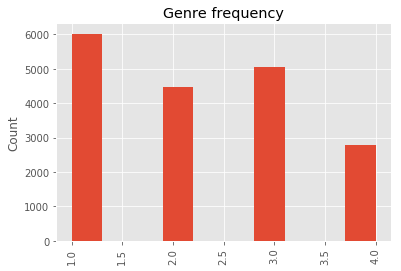

In [3]:
plt.hist(df['genre'])
plt.ylabel('Count')
plt.title('Genre frequency')
plt.xticks(rotation=90)
plt.show()

In [4]:
import seaborn as sb

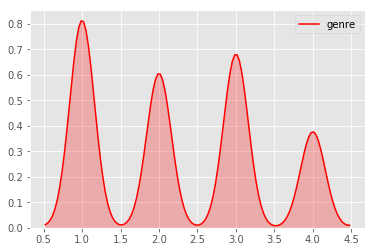

In [5]:
ax = sb.kdeplot(df["genre"], shade=True, color="r") #Show distribution of genres (classes)

In [6]:
# separate between features/inputs (X) and target/output variables (y)
mat = df.drop(['artist_name','track_name','track_id'],axis = 1)
print(mat.head())
mat = mat.values
X = mat[:,2:-1].astype("float")
print(X.shape)
y = mat[:,-1].astype("int")
print(y.shape)
ind = mat[:,0].astype("int")+1


   Unnamed: 0  Unnamed: 0.1  popularity  acousticness  danceability  \
0           0             0          67       0.13900         0.725   
1           1             1          71       0.01580         0.870   
2           2             2          71       0.12500         0.813   
3           3             3          70       0.00980         0.922   
4           4             4          74       0.00022         0.524   

   duration_ms  energy  instrumentalness  key  liveness  loudness  mode  \
0       181867   0.659          0.000000    9    0.1060    -4.537     1   
1       191410   0.656          0.000000    8    0.1060    -5.081     1   
2       224533   0.703          0.000001   11    0.2370    -5.077     0   
3       261615   0.583          0.000000    5    0.0962    -4.982     1   
4       184867   0.939          0.000000    9    0.6230    -3.994     1   

   speechiness    tempo  time_signature  valence  genre  
0       0.2460  160.062               4    0.560      4  
1     

In [7]:
# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

Train/test split:

In [8]:
train_perc = 0.66 # percentage of training data
split_point = int(train_perc*len(y))
perm = np.random.permutation(len(y))
ix_train = perm[:split_point]
ix_test = perm[split_point:]
X_train = X[ix_train,:]
X_test = X[ix_test,:]
ind_train = ind[ix_train]
ind_test = ind[ix_test]
y_train = y[ix_train]
y_test = y[ix_test]
print("num train: %d" % len(y_train))
print("num test: %d" % len(y_test))

num train: 12094
num test: 6231


In [9]:
ix_train

array([ 7495, 18249,  9574, ..., 15004,  3138, 17835])

Our baseline logistic regression model from sklearn:

In [10]:
# create and fit logistic regression model
logreg = linear_model.LogisticRegression(solver='lbfgs', multi_class='multinomial')
logreg.fit(X_train, y_train)

# make predictions for test set
y_hat = logreg.predict(X_test)
print("Predictions:", y_hat)
print("True values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

Predictions: [1 2 4 ... 2 4 1]
True values: [4 2 4 ... 2 4 1]
Accuracy: 0.7896003851709196


## Hierarchical logistic regression in STAN

Our dataset consists of multiple observations from various tracks. However, when we build our original logistic regression in STAN, our specification assumes that all tracks share a unique set of bias (alpha) coefficients (beta). In other words, this is equivalent to assuming, for example, that all tracks are equally biased towards a given genre (e.g. pop). This is obviously a very strong assumption. We should allow different tracks to have different biases (alpha).

This can be done by placing a hierarchical prior on the intercepts (alpha). The generative process then becomes:

1. For each class $c \in \{1,\dots,C\}$
    2. Draw global mean parameters $\mu_c \sim \mathcal{N}(0,10)$
    3. Draw global variance parameters $\sigma_c \sim \mbox{Cauchy}(0,10)$
    5. Draw coefficients $\boldsymbol\beta_c \sim \mathcal{N}(\textbf{0},10 \, \textbf{I})$ (this the same as before...)
    6. For each track $i \in \{1,\dots,I\}$
        4. Draw $\alpha_{i,c}$ such that $\alpha_{i,c} \sim \mathcal{N}(\mu_c,\sigma_c)$

6. For each data point $n=\{1,\dots,N\}$
    7. Draw target class $y_n \sim \mbox{Multinomial}(\mbox{Softmax}(\textbf{x}_n,\boldsymbol\alpha_{i_n},\boldsymbol\beta_1,\dots,\boldsymbol\beta_C))$
    
where $i_n$ is the track identifier for track $n$, and $\boldsymbol\mu=\{\mu_1\dots\mu_C\}$ and $\boldsymbol\sigma=\{\sigma_1\dots\sigma_C\}$.

In [42]:
# define Stan model
model_definition = """
data {
    int<lower = 1> N;
    int<lower = 1> D;
    int<lower = 1> C;
    int<lower = 1> I;
    int ind[N];
    matrix[N,D] X;
    int<lower=1,upper=C> y[N];
}

parameters {
    vector<lower=1>[C] mu_prior;
    vector<lower=1>[C] sigma_prior;
    
    matrix[I,C] alpha;
    matrix[C,D] beta;  
    
}

model {
    for (c in 1:C) {
        mu_prior[c] ~ cauchy(c,0.5);
        sigma_prior[c] ~ cauchy(0,1);
        beta[c] ~ normal(2,4); 
        for (i in 1:I){
            alpha[i,c] ~ normal(mu_prior[c],sigma_prior[c]);
        }
    }
    for (n in 1:N){
        y[n] ~ categorical(softmax(alpha[ind[n],:]' + beta * X[n]'));
        
    }    
}
"""

Prepare input data for STAN, compile STAN program and run inference using ADVI (much faster in this case):

In [43]:
# prepare data for Stan model
N, D = X_train.shape
C = int(y_train.max())
I = ind.max()
print("N=%d, D=%d, C=%d, I=%d" % (N,D,C,I))
data = {'N': N, 'D': D, 'C': C, 'I':I, 'ind':ind_train, 'X': X_train, 'y': y_train}

N=12094, D=14, C=4, I=5040


In [44]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code=model_definition)
fit = sm.vb(data=data, iter=10000, algorithm="meanfield", grad_samples=10, seed=42, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1acaeb94f70f4038bfb0b12b2bf6c2d9 NOW.


Wall time: 12min 7s


Lets plot the posterior distributions of some of the parameters of our model (you may have called these variables something else...):

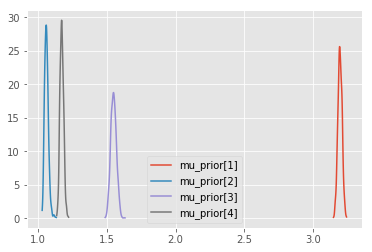

In [45]:
pystan_utils.vb_plot_variables(fit, "mu_prior")

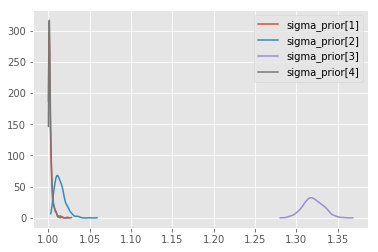

In [46]:
pystan_utils.vb_plot_variables(fit, "sigma_prior")

We can now use the inferred posteriors to make predictions. Lets first use the "pystan_utils" package to extract the expected values of the posterior distribution of the model parameters:

In [47]:
# get fitted parameters
mu_prior = pystan_utils.vb_extract_variable(fit, "mu_prior", var_type="vector")
sigma_prior = pystan_utils.vb_extract_variable(fit, "sigma_prior", var_type="vector")
alpha = pystan_utils.vb_extract_variable(fit, "alpha", var_type="matrix", dims=(C,I))
beta = pystan_utils.vb_extract_variable(fit, "beta", var_type="matrix", dims=(C,D))

Using expected values of the parameters, we can make predictions for the testset. However, we need to account for the fact that we now have different bias parameters per track. 

In [48]:
# make predictions for test set
y_hat = alpha[:,ind_test-1] + np.dot(beta, X_test.T)
y_hat = np.argmax(y_hat, axis=0) + 1
print("predictions:", y_hat)
print("true values:", y_test)

# evaluate prediction accuracy
print("Accuracy:", 1.0*np.sum(y_hat == y_test) / len(y_test))

predictions: [4 2 4 ... 2 4 4]
true values: [4 2 4 ... 2 4 1]
Accuracy: 0.6947520462205103


Given the posterior distributions inferred by STAN, we can even analyse the biases of different individuals identified by our model:

In [ ]:
for i in range(I):
    print(i, alpha[:,i])

Perhaps a histogram allows for a better global analysis:

In [ ]:
# histogram of biases towards mode 4 (car)
plt.hist(alpha[3,:])
plt.title("Biases towards mode 4")
plt.xlabel("alpha[4]")
plt.show()

We can observe that, for most individuals the biases is around 0. However, we can also see that a few individuals really love their cars!

Reflection exercise: can you think of ways in which you could use this model to try to identify policies (e.g. price changes or making terminals more efficient) that would allow to shift people's travel mode choices away from the car (e.g. towards public transport)?